In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from astropy.constants import G, c, M_sun , hbar
import astropy.units as u

plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 150,                   
    "grid.alpha": 0.4,                    
})


# Boson stars

Equation of state in dimensionless units
$$
\epsilon = p ^{2/n} + \frac{n+2}{n-2}p
$$

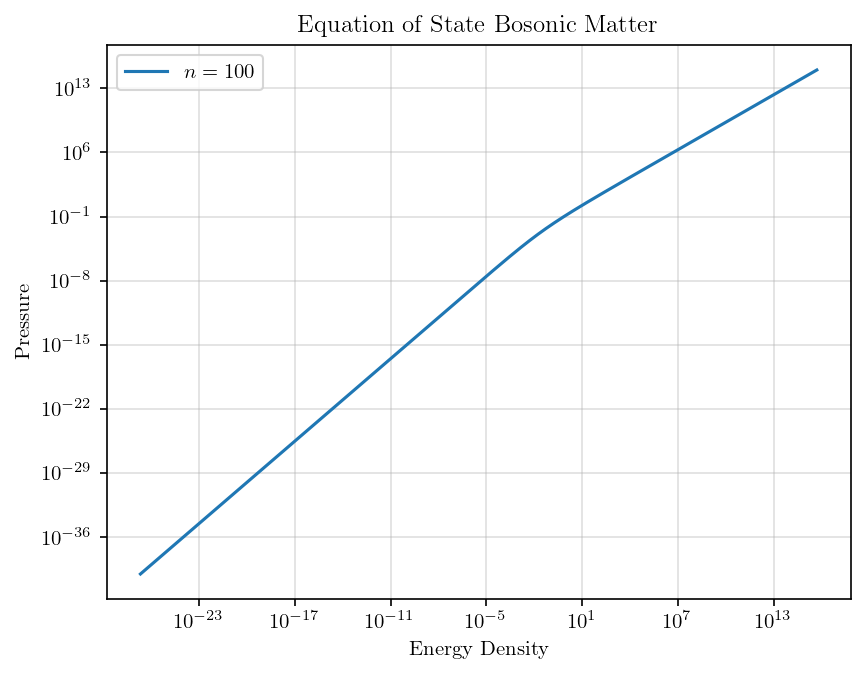

In [138]:
def energy_density(pressure, n):
    return pressure ** (2/n) + ((n + 2) / (n - 2)) * pressure


grid_p_eos = np.logspace(-40, 15, int(1e5))  # Des de molt petit fins a molt gran
grid_e_eos = energy_density(grid_p_eos, 3)

#plot the eos
plt.plot(grid_e_eos, grid_p_eos,  label=f'$n={n}$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Pressure')
plt.xlabel('Energy Density')
plt.title('Equation of State Bosonic Matter')


plt.legend()
plt.grid()
plt.show()


$$
\epsilon = p ^{2/3} + 5 p \qquad n =3
$$

$$
\epsilon = p ^{1/2} + 3 p \qquad n =4
$$

In [139]:
#print maximums and minimums of the curves
print(f'Maximum Pressure for n=3: {max(grid_p_eos)}')
#print(f'Maximum Pressure for n=4: {max(list_p)} at Energy Density: {list_e_n4[np.argmax(list_p)]}')
print(f'Minimum Pressure for n=3: {min(grid_p_eos)}')
#print(f'Minimum Pressure for n=4: {min(list_p)} at Energy Density: {list_e_n4[np.argmin(list_p)]}')
print('----------------------------------')
#pirnt max and mins of energy density
print(f'Maximum Energy Density for n=3: {max(grid_e_eos)}')
#print(f'Maximum Energy Density for n=4: {max(list_e_n4)} at Pressure: {list_p[np.argmax(list_e_n4)]}')
print(f'Minimum Energy Density for n=3: {min(grid_e_eos)}')
#print(f'Minimum Energy Density for n=4: {min(list_e_n4)} at Pressure: {list_p[np.argmin(list_e_n4)]}')


Maximum Pressure for n=3: 1000000000000000.0
Minimum Pressure for n=3: 1e-40
----------------------------------
Maximum Energy Density for n=3: 5000010000000000.0
Minimum Energy Density for n=3: 2.154434690032391e-27


In [140]:

def solve_TOV(central_energy, x0, grid_p_eos, grid_e_eos):

    def ode_TOV(r, x):
        p, M = x

        e = np.interp(p, grid_p_eos, grid_e_eos)

        if r < 1e-8:
            dpdr = 0.0
            dMdr = 4*np.pi*r**2*e
            return [dpdr, dMdr]

        term1 = (e + p)
        term2 = (M + 4*np.pi*r**3*p)
        term3 = r * (r - 2*M)

        dpdr = - term1 * term2 / term3
        dMdr =  4*np.pi * r**2 * e

        return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 1e20),     # integrate up to r=1e5  corresponds to 
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10, #tolerance error
        max_step=0.1
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]


    if P_surface > 1e-10 :
        print("Final pressure is far from 0:", P_surface )
    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R = []
list_M = []

list_p_central_conditions = np.logspace(-10, 5, 200) 
list_e_central_conditions = energy_density(list_p_central_conditions, 3)

for p_central, e_central in zip(list_p_central_conditions, list_e_central_conditions):
    r0 = 1e-6
    central_mass = (4/3) * np.pi * (r0**3) * e_central
    x0 = [p_central, central_mass]


    R_surface, M_surface = solve_TOV(e_central, x0, grid_p_eos, grid_e_eos)


    list_R.append(R_surface)
    list_M.append(M_surface)



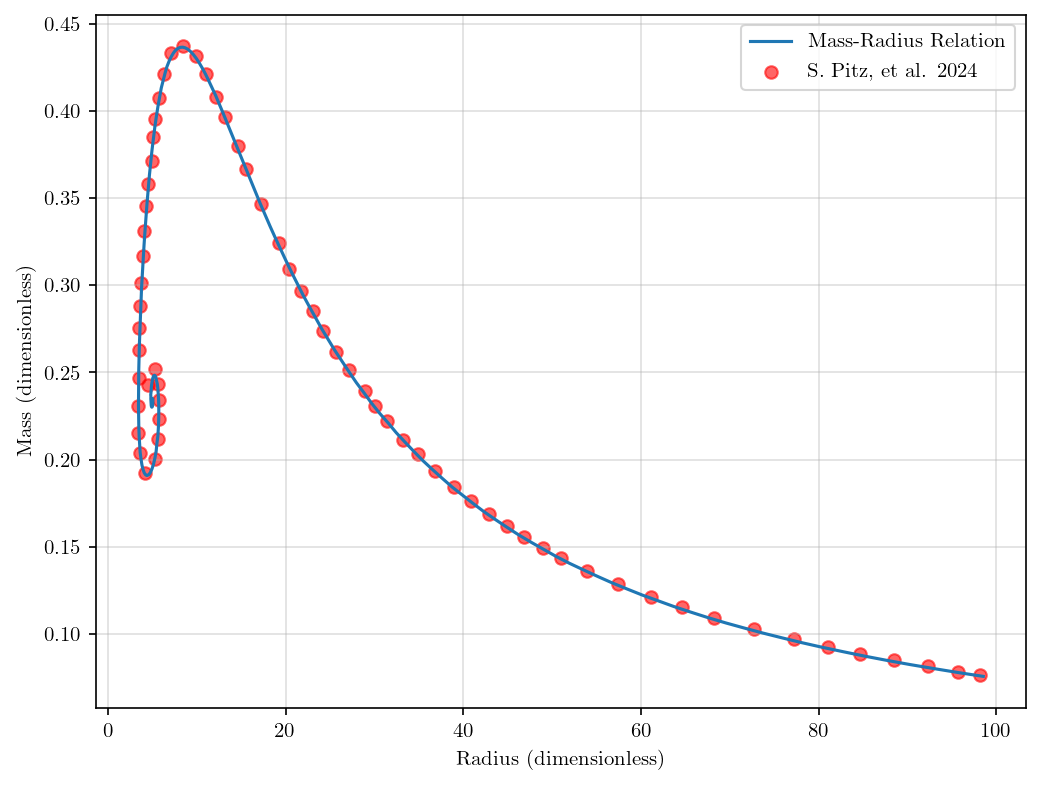

Maximum Mass: 0.4364557559747773 at Radius: 8.39546966048396
Maximum Mass from Data: 0.4369149230410573 at Radius: 8.442324194503579


In [141]:
plt.figure(figsize=(8,6), dpi=150)

plt.plot(np.array(list_R), np.array(list_M), label='Mass-Radius Relation')

data = pd.read_csv('../Data/Mass_Radius_n3.csv')

plt.scatter(data['x'], data[' y'], color='red', label='S. Pitz, et al. 2024', alpha=0.6)


plt.xlabel('Radius (dimensionless)')
plt.ylabel('Mass (dimensionless)')
plt.grid()
plt.legend()
plt.show()
# maxum mass and radius
max_mass = np.max(list_M)
index_max_mass = np.argmax(list_M)
corresponding_radius = list_R[index_max_mass]
print(f'Maximum Mass: {max_mass} at Radius: {corresponding_radius}')

max_mass_data = np.max(data[' y'])
index_max_mass_data = np.argmax(data[' y'])
corresponding_radius_data = data['x'][index_max_mass_data]
print(f'Maximum Mass from Data: {max_mass_data} at Radius: {corresponding_radius_data}')


I will authomatize the preocess, to check for the rest of n

In [142]:
list_of_n = [4, 5, 6, 7, 9, 20, 30, 40, 70, 90, 100]
all_list_R = []
all_list_M = []

def Mass_radius(n):

    list_p_central_conditions = np.logspace(-10, 5, 200) 
    list_e_central_conditions = energy_density(list_p_central_conditions, n)
    grid_e_eos = energy_density(grid_p_eos, n)
    list_R = []
    list_M = []

    for p_central, e_central in zip(list_p_central_conditions, list_e_central_conditions):
        r0 = 1e-6
        central_mass = (4/3) * np.pi * (r0**3) * e_central
        x0 = [p_central, central_mass]


        R_surface, M_surface = solve_TOV(e_central, x0, grid_p_eos, grid_e_eos)


        list_R.append(R_surface)
        list_M.append(M_surface)

    all_list_R.append(list_R)
    all_list_M.append(list_M)

    return all_list_R, all_list_M

In [143]:
for n in list_of_n:
    all_list_R, all_list_M = Mass_radius(n)

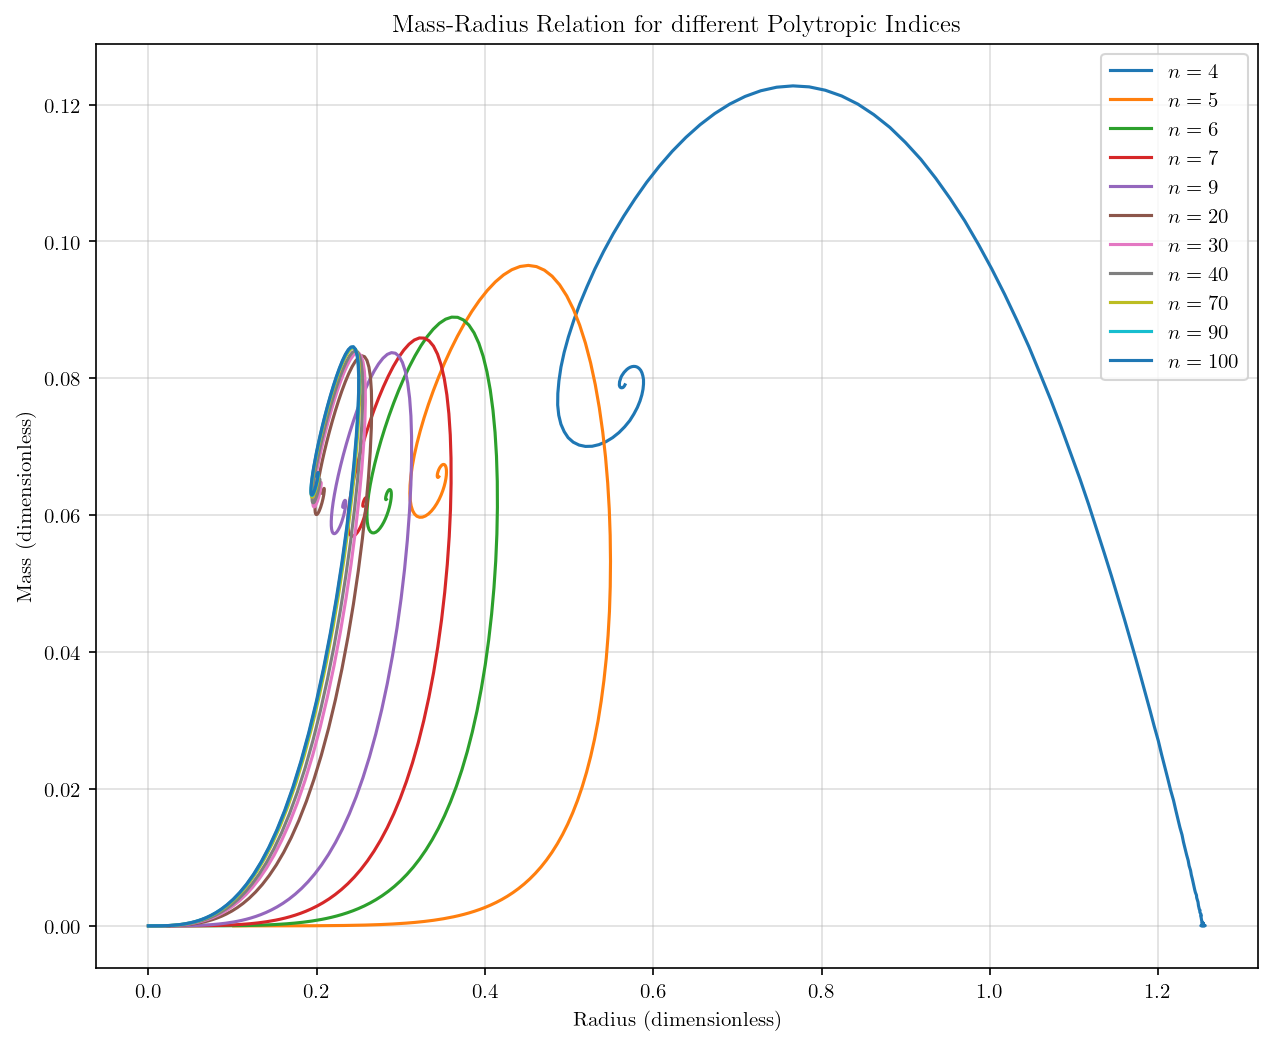

In [144]:
# Plotting the results
plt.figure(figsize=(10, 8), dpi=150)
for i, n in enumerate(list_of_n):
    plt.plot(np.array(all_list_R[i]), np.array(all_list_M[i]), label=f'$n={n}$')
plt.xlabel('Radius (dimensionless)')
plt.ylabel('Mass (dimensionless)')
plt.title('Mass-Radius Relation for different Polytropic Indices')
plt.legend()
plt.grid()
plt.show()

hauria de comprovar que passa a grans M, R (condicions inicials petites(crec)), perque ja a la DM tinc valors diferents. 
Acabo de canviar el low limit de la EoS, a un de mes baix i ja tinc resultats bons. crec que hauria de separar la EoS grid ( que vagi fins a valors molt pwtits), i despres la llista de condicins inicials, no cal que vagi a valors tan petits.


Arreglat! Ja funciona. Ara canviar el codi de la DM (quan pugui per arreglar això)


Next step, two fluids

# Rescale

The copling strength is very important


In [153]:
lamb = 1 #coupling strength
m_b = 1e5 # MeV
n = 3 

epsilon_0 = lamb * ( n / 2 - 1) * m_b ** n  # MeV^4

M_p = 1.2209e22  # MeV
G = 1 / M_p **2

hc = 197.3269804 # MeV fm

mass_scale_factor = (G **3 * epsilon_0) ** (-1/2) # MeV 
mass_scale_factor_solar = mass_scale_factor / (M_sun.to(u.MeV/c**2).value)  # in solar masses

radius_scale_factor = (G  * epsilon_0) ** (-1/2) # MeV^-1 
radius_scale_factor_km = radius_scale_factor * (hc * 1e-18)  # km



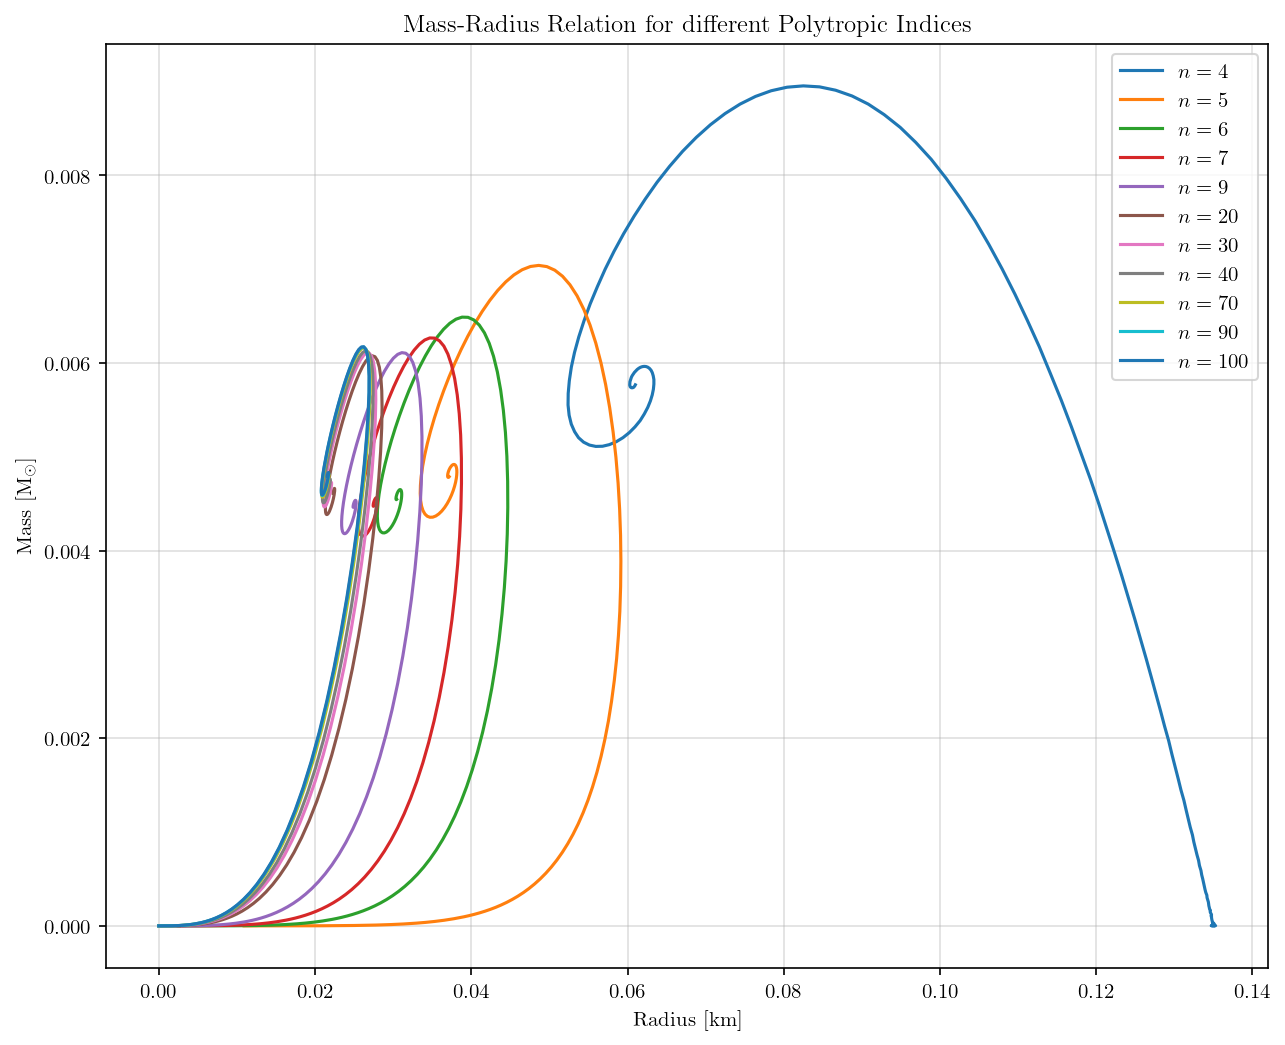

In [154]:
# Plotting the results
plt.figure(figsize=(10, 8), dpi=150)
all_list_R_km = [0] * len(list_of_n)
all_list_M_solar = [0] * len(list_of_n)
for i, n in enumerate(list_of_n):
    all_list_R_km[i] = np.array(all_list_R[i]) * radius_scale_factor_km
    all_list_M_solar[i] = np.array(all_list_M[i]) * mass_scale_factor_solar
    plt.plot(np.array(all_list_R_km[i]), np.array(all_list_M_solar[i]), label=f'$n={n}$')
plt.xlabel('Radius [km]')
plt.ylabel('Mass [M$_\odot$]')
plt.grid()
plt.title('Mass-Radius Relation for different Polytropic Indices')
plt.legend()

plt.show()